In [1]:
import itertools as it
import warnings

import numpy as np
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
from deap import base, creator, tools, algorithms
import seaborn as sns

sns.set()

In [2]:
def make_regression(func, n_elements, noise=0.0, random_state=None):
    rng = np.random.RandomState(random_state)
    x = rng.uniform(5.0, size=n_elements)
    n = rng.normal(scale=noise, size=n_elements)
    y = func(x) + n
    return x.reshape(-1, 1), y

def plot_regression_line(clf, xb, yb, n=100):
    xx = np.linspace(*xb, n).reshape(-1, 1)
    yy = clf.predict(xx)
    plt.plot(xx, yy, color='red', linewidth=20, alpha=0.3)

In [3]:
X, y = make_regression(lambda x: x**2 + 2*x, 1000, random_state=0, noise=5.0)
train_X, test_X, train_y, test_y = train_test_split(X, y, random_state=0, test_size=0.2)
train_X, dev_X, train_y, dev_y = train_test_split(train_X, train_y, random_state=0, test_size=0.15)

In [4]:
epsilon = 1e-9
rng = np.random.RandomState(0)

def plus_minus(value, max_pm, min_v, max_v, is_int=False):
    if is_int:
        pm = rng.randint(-max_pm, max_pm+1)
    else:
        pm = rng.uniform(-max_pm, max_pm+epsilon)
    return max(min(value + pm, max_v), min_v)

parameters = [
    ('kernel',  lambda: rng.choice(['poly', 'rbf']),   lambda x: 'poly' if x == 'rbf' else 'poly'),
    ('degree',  lambda: rng.randint(1, 5),             lambda x: plus_minus(x, 2, 1, 6, True)),
    ('gamma',   lambda: rng.choice(['auto', 'scale']), lambda x: 'auto' if x == 'scale' else 'auto'),
    ('C',       lambda: rng.uniform(0.01, 5.0),       lambda x: plus_minus(x, 2.0, 0.01, 5.0)),
    ('epsilon', lambda: rng.uniform(0.01, 5.0),       lambda x: plus_minus(x, 2.0, 0.01, 5.0)),
]

pnames, pgens, pmuts = list(zip(*parameters))

def create_sample():
    return [g() for g in pgens]

def sample_to_params(ind):
    return dict(zip(pnames, ind))

def train_model_from_sample(sample):
    params = sample_to_params(sample)
    clf = SVR(**params)
    clf.fit(train_X, train_y)
    return clf

def model_evaluation(sample):
    clf = train_model_from_sample(sample)
    pred = clf.predict(dev_X)
    return -mean_squared_error(dev_y, pred),

def mutate_sample(ind, indpb):
    for i, mut in enumerate(pmuts):
        if rng.rand() > indpb:
            ind[i] = mut(ind[i])
    return ind,

In [5]:
creator.create('FitnessMax', base.Fitness, weights=(1.0,))
creator.create('Individual', list, fitness=creator.FitnessMax)
toolbox = base.Toolbox()
toolbox.register('individual', lambda: creator.Individual(create_sample()))
toolbox.register('population', tools.initRepeat, list, toolbox.individual)
toolbox.register('evaluate', model_evaluation)
toolbox.register('mate', tools.cxUniform, indpb=0.5)
toolbox.register('mutate', mutate_sample, indpb=0.5)
toolbox.register('select', tools.selTournament, tournsize=5)
hof = tools.HallOfFame(10)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)
pop = toolbox.population(10)
lb = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.5, ngen=10, stats=stats, halloffame=hof)

gen	nevals	avg     	std   	min     	max     
0  	10    	-22.7456	1.0049	-24.8622	-20.9262
1  	7     	-22.9835	3.43365	-32.6501	-20.8897
2  	6     	-20.898 	0.0179006	-20.9262	-20.8721
3  	5     	-21.0844	0.631628 	-22.9792	-20.8721
4  	9     	-21.0892	0.630144 	-22.9787	-20.8654
5  	6     	-21.4906	1.31004  	-24.8979	-20.8654
6  	10    	-20.8661	0.00199358	-20.8721	-20.8653
7  	7     	-22.0222	1.91405   	-26.3093	-20.8653
8  	9     	-22.2012	2.18795   	-26.3999	-20.8654
9  	5     	-21.4941	1.30085   	-24.8979	-20.8654
10 	8     	-20.8801	0.0200916 	-20.9256	-20.8653


In [6]:
list(hof)

[['poly', 3, 'auto', 2.4376608040509025, 4.283988965814987],
 ['poly', 3, 'auto', 2.6264417976901013, 4.283988965814987],
 ['poly', 3, 'auto', 3.3463731940802126, 4.283988965814987],
 ['poly', 3, 'auto', 4.045762578469828, 4.283988965814987],
 ['poly', 3, 'auto', 4.160352331322516, 4.283988965814987],
 ['poly', 3, 'auto', 4.3045763750169135, 4.283988965814987],
 ['poly', 3, 'auto', 5.0, 4.283988965814987],
 ['poly', 3, 'auto', 3.3463731940802126, 4.869046715719991],
 ['poly', 3, 'auto', 4.964964171822914, 5.0],
 ['poly', 3, 'auto', 4.346370189910614, 5.0]]

In [7]:
best_clf = train_model_from_sample(hof[0])
best_clf.fit(train_X, train_y)

SVR(C=2.4376608040509025, cache_size=200, coef0=0.0, degree=3,
    epsilon=4.283988965814987, gamma='auto', kernel='poly', max_iter=-1,
    shrinking=True, tol=0.001, verbose=False)

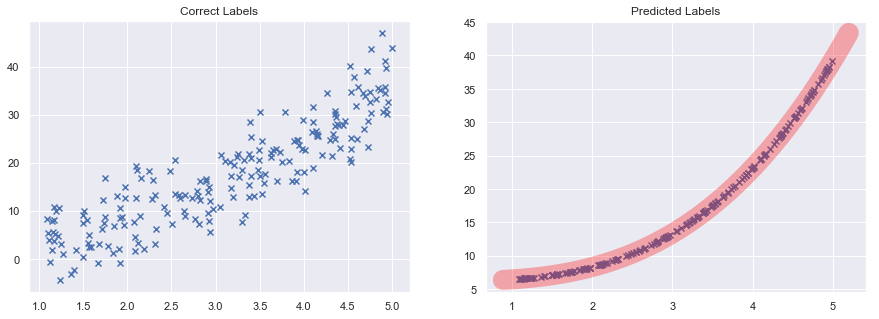

In [8]:
plt.figure(figsize=(15, 5))
pred = best_clf.predict(test_X)
plt.subplot(1, 2, 1)
plt.title('Correct Labels')
plt.scatter(test_X.ravel(), test_y, marker='x')
plt.subplot(1, 2, 2)
plt.title('Predicted Labels')
plt.scatter(test_X.ravel(), pred, marker='x')
plot_regression_line(best_clf, plt.xlim(), plt.ylim())
plt.show()